In [1]:
import logging
import warnings

import numpy as np
import os
import sys
import pybedtools
from pybedtools import BedTool
import collections
import csv
import matplotlib.pyplot as plt
import gzip
import loompy
import scipy.sparse as sparse
import json
import urllib.request

sys.path.append('/home/camiel/chromograph/')
import chromograph
from chromograph.preprocessing.utils import *

# from .config import Config

In [2]:
logger = logging.getLogger()
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%H:%M:%S')

In [8]:
sampleid = '10X232_3
indir = f"/data/proj/chromium/{sampleid}}"

sample = indir.split('/')[-1]
bsize = 5000
genome_size = None
f_blacklist = None
level = 5000
outdir = '/data/proj/scATAC/chromograph/{}'.format(indir.split('/')[-1])

In [9]:
fb = indir + '/outs/singlecell.csv'
ff = indir + '/outs/fragments.tsv.gz'
fs = indir + '/outs/summary.json'

if not os.path.isdir(outdir):
    os.mkdir(outdir)

with open(fs, "r") as f:
    summary = json.load(f)
    
    for k,v in summary.items():
        summary[k] = str(v)

summary['bin_size'] = bsize
summary['level'] = level

# bamfile = pysam.AlignmentFile(fbam, "rb", index_filename=fi)
barcodes = np.genfromtxt(fb, delimiter=',', skip_header=2,
                         dtype={'names':('barcode','total','duplicate','chimeric','unmapped','lowmapq','mitochondrial','passed_filters','cell_id','is__cell_barcode',
                                           'TSS_fragments','DNase_sensitive_region_fragments','enhancer_region_fragments','promoter_region_fragments','on_target_fragments',
                                           'blacklist_region_fragments','peak_region_fragments','peak_region_cutsites'),
                                 'formats':('U18', 'i8', 'i8', 'i8', 'i8', 'i8', 'i8', 'i8', 'U18', 'i8', 'i8', 'i8', 'i8', 'i8', 'i8', 'i8', 'i8', 'i8')})

## Transfer metadata to dict format
meta = {}
for key in barcodes.dtype.names:
    passed = np.logical_and(barcodes['is__cell_barcode'] == 1, barcodes['passed_filters'] > level)
    meta[key] = barcodes[key][passed]
meta['sample'] = np.repeat(sample, len(meta['barcode']))
logging.info("Total of {} valid cells".format(len(meta['barcode'])))

# Get Chromosome sizes
if genome_size == None:
    chrom_size = get_chrom_sizes(summary['reference_assembly'])    
else:
    chrom_size = {}
    with open(genome_size) as f:
        for line in f:
            x = line.split()
            chrom_size[x[0]] = int(x[1])

15:26:50 INFO     Total of 4681 valid cells
15:26:50 INFO     Loaded chromatin sizes for GRCh38


In [10]:
## Read Fragments and generate size bins
logging.info("Read fragments into dict")
frag_dict = read_fragments(ff)

# logging.info(f"Saving fragments as np.array")
# meta['fragments'] = [np.array(frag_dict[k]) for k in meta['barcode']]

logging.info("Saving fragments to dict")
fpick = outdir + '/' + sampleid + '_frags.pkl'
pickle.dump(frag_dict, fpick)

logging.info("Generate {} bins based on provided chromosome sizes".format(str(int(bsize/1000)) + ' kb'))
chrom_bins = generate_bins(chrom_size, bsize=bsize)

15:26:58 INFO     Read fragments into dict
15:27:28 INFO     barcodes: 103957   fragments: 7593326
15:27:28 INFO     Saving fragments as np.array
15:27:35 INFO     Generate 5 kb bins based on provided chromosome sizes
15:27:36 INFO     Number of bins: 617669


## Count fragments inside bins based on cell barcodes

In [7]:
logging.info(f"Counting fragments in bins")
Count_dict = count_fragments(frag_dict, meta['barcode'], summary['bin_size'])

11:02:52 INFO     Counting fragments in bins
11:04:28 INFO     Finished counting 500 cells
11:05:54 INFO     Finished counting 1000 cells
11:07:32 INFO     Finished counting 1500 cells
11:09:10 INFO     Finished counting 2000 cells
11:10:36 INFO     Finished counting 2500 cells
11:12:14 INFO     Finished counting 3000 cells
11:13:38 INFO     Finished counting 3500 cells
11:15:09 INFO     Finished counting 4000 cells
11:16:31 INFO     Finished counting 4500 cells
11:17:56 INFO     Finished counting 5000 cells


## Remove blacklisted regions

In [ ]:
## Download Blacklist

# Load Blacklist
if f_blacklist == None:
    f_blacklist = get_blacklist(summary['reference_assembly'])    

blacklist = BedTool(f_blacklist)
bins = [(k[0], str(k[1]), str(k[2])) for k in chrom_bins.keys()]
intervals = pybedtools.BedTool(bins)
cleaned = intervals.subtract(blacklist, A=True)

keep = [(row['chrom'], int(row['start']), int(row['end'])) for row in cleaned]
retain = [chrom_bins[x] for x in keep]
clean_bin = [bins[x] for x in retain]

print('Number of bins after cleaning: {}'.format(len(clean_bin)))

## Construct loom file

In [ ]:
## Create sparse matrix
col = []
row = []
v = []

cix = 0
for cell in meta['barcode']:
    
    for key in (Count_dict[cell]):
        col.append(cix)
        row.append(chrom_bins[key])
        v.append(Count_dict[cell][key])
    cix+=1

matrix = sparse.coo_matrix((v, (row,col)), shape=(len(chrom_bins.keys()), len(meta['barcode'])))

## Save a smaller section of the summary
keys = ['cellranger-atac_version', 'reference_assembly', 'reference_assembly_accession', 'reference_assembly_fasta_url', 'reference_organism', 'reference_version', 'bin_size']
small_summary = {k: summary[k] for k in keys}

## We retain only the bins that have no overlap with the ENCODE blacklist
cleaned_matrix = matrix.tocsr()[retain,:]
print('Identified {} positive bins in {} cells before filtering blacklist'.format(len(v), len(meta['barcode'])))
print('Identified {} positive bins in {} cells after filtering blacklist'.format(len(cleaned_matrix.nonzero()[0]), len(meta['barcode'])))

## Create row attributes
chrom = [x[0] for x in clean_bin]
start = [x[1] for x in clean_bin]
end = [x[2] for x in clean_bin]

row_attrs = {'chrom': chrom, 'start': start, 'end': end}

In [ ]:
## Create loomfile
sampleid = indir.split('/')[-1] + '_' + str(int(bsize/1000)) + 'kb'
f = outdir + '/' + sampleid + '.loom'

loompy.create(filename=f, 
              layers=cleaned_matrix, 
              row_attrs=row_attrs, 
              col_attrs=meta,
              file_attrs=small_summary)

In [ ]:
ds = loompy.connect(f)
# ds.close()

(0, 1)

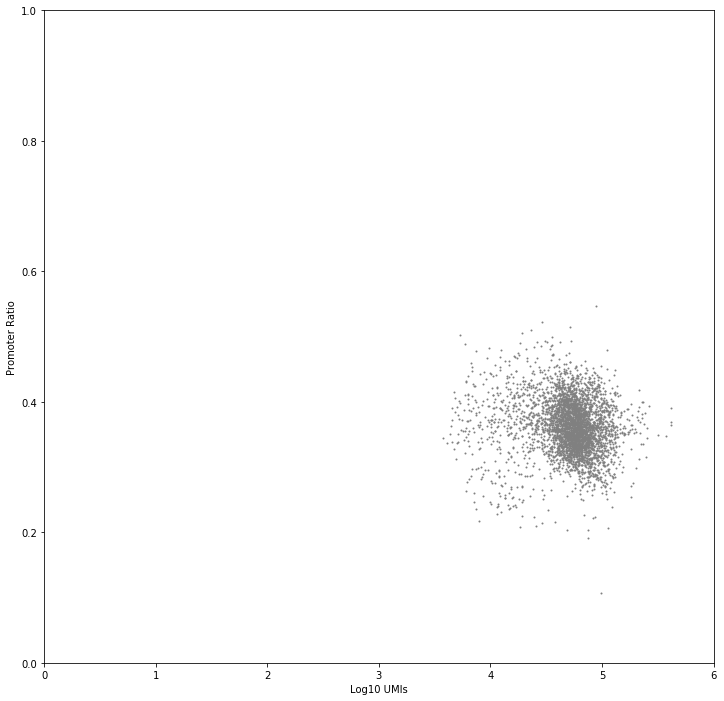

In [15]:
UMIs = np.log10(ds.ca['passed_filters'] + 1)
Prom_rat = (ds.ca['promoter_region_fragments'] + 1) / (ds.ca['passed_filters'] + 1)

fig, ax = plt.subplots(figsize=(12,12))
ax.scatter(UMIs, Prom_rat, s=1, c='grey')
ax.set_xlabel('Log10 UMIs')
ax.set_ylabel('Promoter Ratio')
ax.set_xlim((0,6))
ax.set_ylim((0,1))

In [25]:
nnz = ds.map([np.count_nonzero], axis=1)[0]
nnz

array([2265.,  843.,  522., ...,  540.,  681.,  645.])